Assignment 3: Image Classification using CNNs
===

In this assignment you will learn about
1. The fundamental computations in neural networks for vision, including backpropagation
2. The basics of fitting a model for generalization
3. Nearest neighbor classifiers

**Note:** When you first load this colab webpage, it will be in read-only viewing mode.  To edit and run code, you can either (a) download the Jupyter notebook ("File" -> "Download .ipynb") to run on your local computer or (b) copy to your Google Drive ("File" -> "Save a copy in Drive...") to work in the browser and run on a Google Cloud GPU.  If you run locally, you will need to install Tensorflow and it is recommended that you use a GPU for problem 3.2.  If you do not want to use Colab and do not have a local GPU, please let us know.


# 3.0 Nearest neighbor classification (20 points)

## 3.0.1 (20 points) 
Given the following training set of labeled two-dimensional points for binary classification, draw a Voronoi diagram of the output of a 1-nearest neighbor classifier.  Feel free to render the diagram using Python below (do not use scikit-learn or any machine learning libraries to do this) or submit a PDF along with your assignment.

>```
Point (x,y)  | Label
-------------|-------
(1,3)        |   +
(-4,-2)      |   +
(-3,-1.5)    |   -
(3,3)        |   -
(0,-2)       |   +
(-2,0)       |   +
(-2,4)       |   -
```



In [4]:
#Functions used to find the N-Nearest neighbors for assignment
#The results for the Nearest Neighbor classification were created in Photoshop, 
#and can be found at the NN_Classification\1NN-Voronoi.jpg


import matplotlib.pyplot as plt
import numpy as np

"""
Function to calculate distance between two points

inputs: x1, y1 - datapoint 1
        x2, y2 - datapoint 2
"""
def distance(x1, x2, y1, y2):
    x_diff = x2 - x1
    y_diff = y2 - y1 
    return np.sqrt((x_diff**2)+(y_diff**2))  

"""
Function to find the nearest neighbor

inputs: x_idx,y_idx - the current datapoint to find the nearest neighbors for
        datapoints - the classified datapoints to consider as neighbors
        k - the count of nearest neighbors to consider
"""
def nearest_neighbors(x_idx, y_idx, datapoints, k):
    all_dist = []
    label = 0
    
    #Go through each datapoint
    for point in datapoints:
        
        #Calculate the distance and append to a list
        curr_distance = distance(x_idx, point[0], y_idx, point[1])
        all_dist.append((curr_distance, point[2]))
    
    #sort the list in order of closeness, and limit to the k-nearest neighbors
    sorted_dist = sorted(all_dist, key=lambda x:x[0])
    k_nn = sorted_dist[:k]
    
    #Go through each considered neighbor and impact the value depending on 
    #whether the neighbor was a "+" or a "-", adding and subtracting respectively
    for neighbor in k_nn:
        if(neighbor[1] == "+"):
            label += 1
        else:
            label -= 1
    
    #Indicate label at the point, handling edge case of a tie by looking at the K-1 nearest neighbors
    if(label > 0):
        return "+"
    elif(label < 0):
        return "-"
    else:
        return nearest_neighbors(x_idx, y_idx, datapoints, k-1)

"""
Function to print the indices at which the class changes, between positive and negative

inputs: datapoints - the datapoints with their classes specified
        nn_cnt - the number of datapoints to consider when calculated class
"""
def print_switch_indices(datapoints, nn_cnt):
    #initialize the boundaries
    #Start with 50 and times by .1 to be able to iterate through pixel per tenth
    H = W = 50
    for i in range(-H,H):
        curr_class = ""       
        i *= .1
        output = ""
        for j in range(-W,W):
            j *= .1

            label = nearest_neighbors(j, i, datapoints, nn_cnt)
            if(label != curr_class):
                output += " "+ str(j) + "," + str(i) + " switched to " + label
                curr_class = label
        print(output ,"\n")

#Initialize the datapoints
datapoints = [(1, 3, "+"), (-4, -2, "+"), (-3, -1.5, "-"), (3, 3, "-"), (0, -2, "+"), (-2, 0, "+"), (-2, 4, "-")]
#Find nearest neighbors
print_switch_indices(datapoints, 1)

## 3.0.2 (5 points, extra) 

Render for 3-NN

In [5]:
#The results for the Nearest Neighbor classification were created in Photoshop, 
#and can be found at the NN_Classification\3NN-Voronoi.jpg

#Find nearest neighbors
print_switch_indices(datapoints, 3)

# 3.1 Neural network operations (40 points)

In this section we provide a working example of a convolutional neural network written using basic numpy operations.  Each neural network operation is represented by a Python class with methods *forward()* and *backward()*, which compute activations and gradients, respectively. Your task is to complete certain methods that are left blank.

1. 2D Convolution
> * Forward
> * **Backward (10 points)**
2. ReLU
> * **Forward (5 points)**
> * Backward
3. Average pooling
> * Forward
> * **Backward (5 points)**
4. Softmax cross-entropy
> * **Forward (10 points)**
> * Backward

When you complete an operation, you can check your work by executing its cell.  We compare the outputs of your method to that of Tensorflow.

Finally, when you have all of the operations completed, you can run a small network for a few iterations of stochastic gradient descent and plot the loss.


In [1]:
#@title (Hidden utility code: RUN ME FIRST) { display-mode: "form" }
import tensorflow as tf
import numpy as np

class Variable:
  """Placeholder for labels and input images"""
  value = 0

def cmp_ops(your_op, tf_op, tf_inputs, tf_weights=None):
  your_op.forward()
  your_op_f_out = your_op.value

  with tf.Session().as_default():
    tf_op_f_out = tf_op.eval()[0] # Remove the batch dimension

  print("Forward pass:")
  cmp_tensors(your_op_f_out, tf_op_f_out, verbose=False)

  your_op.inputs.dloss_dvalue = np.zeros(your_op.inputs.value.shape)
  your_op.dloss_dvalue = np.ones(your_op.value.shape)
  your_op.backward()
  your_op_g_inputs = your_op.inputs.dloss_dvalue

  if tf_weights is not None:
    your_op_g_weights = your_op.dloss_dweights
    g_inputs, g_weights = tf.gradients(tf.reduce_sum(tf_op), [tf_inputs, tf_weights])
    
    with tf.Session() as sess:
      tf_g_inputs_out, tf_g_weights_out = sess.run([g_inputs, g_weights])
      tf_g_weights_out = np.transpose(tf_g_weights_out, [3,0,1,2])
    
    print("Gradient wrt inputs:")
    cmp_tensors(your_op_g_inputs, tf_g_inputs_out[0])
    print("Gradient wrt weights:")
    cmp_tensors(your_op_g_weights, tf_g_weights_out)
    
  else:
    g_inputs = tf.gradients(tf.reduce_sum(tf_op), [tf_inputs])

    with tf.Session() as sess:
      tf_g_inputs_out = sess.run(g_inputs)

    print("Gradient wrt inputs:")
    cmp_tensors(your_op_g_inputs, tf_g_inputs_out[0], verbose=False)

def cmp_tensors(yours, tfs, verbose=False):
  print("  Your Op shape: " + str(yours.shape))
  print("  TensorFlow Op shape: " + str(tfs.shape))
  print("  Values equal: " + str(np.allclose(tfs, yours, atol=1e-6)))
  if verbose:
    print(tfs)
    print(yours)
    
inputs = Variable()
inputs.value = np.random.normal(size=(10, 10, 3)) # Input image is 10x10x3
tf_inputs = tf.constant(inputs.value[np.newaxis, ...], dtype=tf.float32)

## 3.1.1 2D Convolution (10 pts)

In [2]:
import numpy as np

"""rows x cols x filters"""

class OpConv2D:
  """Two-dimensional convolutional layer"""
    
  def __init__(self, filters, kernel_size, inputs):
    # Shape of the input feature map
    input_height = inputs.value.shape[0]
    input_width = inputs.value.shape[1]
    input_filters = inputs.value.shape[2]
    
    # Shape of this layer's feature map
    self.height = input_height - kernel_size + 1
    self.width = input_width - kernel_size + 1
    self.filters = filters
    
    self.inputs = inputs
    #Attempted extra credit function implementation here
    #self.inputs = self.pad_inputs(inputs)
    self.kernel_size = kernel_size
    self.weights = np.random.normal(size=(filters, kernel_size, kernel_size, input_filters), scale=0.1)
    self.reset_values()
    
  def reset_values(self):
    self.value = np.zeros((self.height, self.width, self.filters))
    self.dloss_dvalue = np.zeros(self.value.shape)
    self.dloss_dweights = np.zeros(self.weights.shape)
    
  def forward(self):
    # Reset value and gradient at start of forward pass
    self.reset_values()
    
    for y in range(self.height):
      for x in range(self.width):
        for f in range(self.filters):
          z = 0.0
          
          for ky in range(self.kernel_size):
            for kx in range(self.kernel_size):
              for kf in range(self.weights.shape[3]):
                z += self.inputs.value[y+ky, x+kx, kf] * self.weights[f, ky, kx, kf]
                
          self.value[y, x, f] = z
          
  def backward(self):
    ## Complete this method, which sets:
    ## 1. Partial derivative of the loss with respect to the values of the inputs
    ## self.inputs.dloss_dvalue, which is a `height x width x input_filters` tensor
    ## 2. Partial derivative of the loss with respect to the weights
    ## self.dloss_dweights, which is a `filters x kernel_size x kernel_size x input_filters` tensor
    ##
    ## This will utilize tensors:
    ## 1. The partial with respect to the value of this layer
    ## self.dloss_dvalue, a `height x width x filter` tensor
    ## 2. The weights of this layer
    ## self.weights, a `filters x kernel_size x kernel_size x input_filters` tensor
    ## 3. The value of the input layer
    ## self.inputs.value, a `height x width x input_filters` tensor
    pass

    for y in range(self.height):
      for x in range(self.width):
        for f in range(self.filters): 
            
          for ky in range(self.kernel_size):
            for kx in range(self.kernel_size):
              for kf in range(self.weights.shape[3]):
                self.inputs.dloss_dvalue[y+ky, x+kx, kf] += self.weights[f, ky, kx, kf] * self.dloss_dvalue[y, x, f]
                self.dloss_dweights[f, ky, kx, kf] += self.inputs.value[y+ky, x+kx, kf] * self.dloss_dvalue[y, x, f]

    """
    Attempted function to pad the input image with 0s for extra credit
    Intention was to replace line in __init__ "self.inputs = inputs"
    with "self.inputs = self.pad_inputs(inputs)" 
    However, when in use, result turned false so not used  

    inputs: inputs - input shape to be padded with 0s
            
    """                
  def pad_inputs(self, inputs):
    #Add half kernel size to both ends of the image
    self.half_k_size = int((kernel_size-1)/2)

    # Shape of the input feature map with paddinf
    input_height = inputs.value.shape[0] + (2*self.half_k_size)
    input_width = inputs.value.shape[1] + (2*self.half_k_size)
    
    #Initialize padded input to be returned
    padded_inputs = Variable()
    padded_inputs.value = np.zeros((input_height, input_width, self.filters))
    
    for y in range(0, inputs.value.shape[0]):
      for x in range(0, inputs.value.shape[1]):
        for f in range(0, inputs.value.shape[2]):
          #Copy each input into the padded output
          padded_inputs.value[x+self.half_k_size][y+self.half_k_size][f] = inputs.value[y][x][f]
    
    # Update feature map
    self.height = input_height - kernel_size + 1
    self.width = input_width - kernel_size + 1
    
    return padded_inputs
                
  def gradient_step(self, step_size):
    self.weights -= step_size * self.dloss_dweights
    
# Double check that op matches tensorflow
print("Testing Conv2D...")
op1 = OpConv2D(4, 3, inputs)

tf_weights = tf.constant(np.transpose(op1.weights, [1,2,3,0]), dtype=tf.float32)
tf_op1 = tf.nn.conv2d(tf_inputs,
                      tf_weights,
                      [1,1,1,1],
                      'VALID')
cmp_ops(op1, tf_op1, tf_inputs, tf_weights)

Testing Conv2D...
Forward pass:
  Your Op shape: (8, 8, 4)
  TensorFlow Op shape: (8, 8, 4)
  Values equal: True
Gradient wrt inputs:
  Your Op shape: (10, 10, 3)
  TensorFlow Op shape: (10, 10, 3)
  Values equal: True
Gradient wrt weights:
  Your Op shape: (4, 3, 3, 3)
  TensorFlow Op shape: (4, 3, 3, 3)
  Values equal: True


## 3.1.2 ReLU (5 pts)

In [3]:
class OpRelu:
  """Elementwise relu operator"""
    
  def __init__(self, inputs):
    # Shape of the input feature map
    self.input_shape = inputs.value.shape
    self.inputs = inputs
    self.reset_values()
    
  def reset_values(self):
    self.value = np.zeros(self.inputs.value.shape)
    self.dloss_dvalue = np.zeros(self.inputs.value.shape)
    
  def forward(self):
    # Reset value and gradient at start of forward pass
    self.reset_values()
    height, width, filters = inputs.value.shape 
    for y in range(self.input_shape[0]):
      for x in range(self.input_shape[1]):
        for f in range(self.input_shape[2]):
          self.value[y, x, f] = max(self.inputs.value[y, x, f], 0)

            
    ## Complete this code by setting self.value using self.inputs.value
    #self.value = self.inputs.value > 0 ? self.inputs.value : 0
          
  def backward(self):
    self.inputs.dloss_dvalue = self.dloss_dvalue * np.greater(self.value, 0.0)
                
  def gradient_step(self, step_size):
    pass    
  
# Double check that each op matches tensorflow
print("\nTesting Relu...")
op2 = OpRelu(inputs)
tf_op2 = tf.nn.relu(tf_inputs)
cmp_ops(op2, tf_op2, tf_inputs)


Testing Relu...
Forward pass:
  Your Op shape: (10, 10, 3)
  TensorFlow Op shape: (10, 10, 3)
  Values equal: True
Gradient wrt inputs:
  Your Op shape: (10, 10, 3)
  TensorFlow Op shape: (1, 10, 10, 3)
  Values equal: True


## 3.1.3 Average Pooling (5 pts)

In [4]:
class OpAvgPool:
  """Average pooling layer. Non-overlapping cells."""
    
  def __init__(self, cell_size, inputs):
    # Shape of the input feature map
    self.input_height = inputs.value.shape[0]
    self.input_width = inputs.value.shape[1]
    self.input_filters = inputs.value.shape[2]
    
    # Shape of this layer's feature map
    self.height = int((self.input_height + cell_size - 1) / cell_size)
    self.width = int((self.input_width + cell_size - 1) / cell_size)
    self.filters = self.input_filters
    
    self.inputs = inputs
    self.cell_size = cell_size
    self.reset_values()
    
  def reset_values(self):
    self.value = np.zeros((self.height, self.width, self.filters))
    self.dloss_dvalue = np.zeros(self.value.shape)
    
  def forward(self):
    # Reset value and gradient at start of forward pass
    self.reset_values()
    
    for y in range(self.height):
      for x in range(self.width):
        for f in range(self.filters):
          z = 0.0

          for ky in range(min(self.cell_size, self.input_height - y*self.cell_size)):
            for kx in range(min(self.cell_size, self.input_width - x*self.cell_size)):
              z += self.inputs.value[self.cell_size*y+ky, self.cell_size*x+kx, f]
                
          self.value[y, x, f] = z / (self.cell_size * self.cell_size)
          
  def backward(self):
    ## Complete this method by setting the partial with repect to the values of the inputs
    ## self.inputs.dloss_dvalue, an `input_height x input_width x filters` tensor
    ## This will use the partial with respect to the value of this layer
    ## self.dloss_dvalue, a `height x width x filters` tensor
    d_xsq = float(1)/((self.cell_size * self.cell_size)) 

    for y in range(self.input_height):
      for x in range(self.input_width):
        for f in range(self.input_filters):
          curr_x = int(x/2)
          curr_y = int(y/2)
          self.inputs.dloss_dvalue[y, x, f] = self.dloss_dvalue[curr_y, curr_x, f] * d_xsq
                
  def gradient_step(self, step_size):
    pass
  
# Double check that each op matches tensorflow
print("\nTesting AvgPool...")
op3 = OpAvgPool(2, inputs)
tf_op3 = tf.nn.avg_pool(tf_inputs, [1, 2, 2, 1], [1,2,2,1], "VALID")
cmp_ops(op3, tf_op3, tf_inputs)





Testing AvgPool...
Forward pass:
  Your Op shape: (5, 5, 3)
  TensorFlow Op shape: (5, 5, 3)
  Values equal: True
Gradient wrt inputs:
  Your Op shape: (10, 10, 3)
  TensorFlow Op shape: (1, 10, 10, 3)
  Values equal: True


## 3.1.4 Softmax Cross-entropy Loss (10 pts)

In [5]:
import math

class OpSoftmaxCrossEntropyLoss:
  """Cross-entropy loss."""
    
  def __init__(self, logits, true_label):
    """
    inputs:
      logits: shape [1,1,num_classes]
      true_label: scalar in range [0, num_classes-1]
    """
    
    # Shape of the input feature map
    self.num_classes = logits.value.shape[2]
    self.inputs = logits
    self.true_label = true_label
    
  def reset_values(self):
    self.max_label = 0
    self.value = np.zeros((1,))
    self.softmax_prob = np.zeros((self.num_classes,))
    
  def forward(self):
    # Reset value and gradient at start of forward pass
    self.reset_values()
    ## Complete this method by:
    ## (1) setting self.value to the scalar value of the 
    ##     negative log probability of the true class under a Softmax distribution.
    ##     Loss = -ln(exp(y_true) / sum_j (exp(y_j))), where y_j is the logits
    ##     value for class j.
    ## (2) setting self.softmax_prob to the vector representing the probability
    ##     of each class according to the Softmax distribution
    ##     softmax_prob[j] = exp(y_i) / sum_j (exp(y_j)), where y_j is the logits
    ##     value for class j.
    ## This will use
    ## self.inputs.value, a `1 x 1 x num_classes` tensor containing the logits
    sum_exp_logits = 0
    
    for i in range(self.num_classes):
        sum_exp_logits += math.exp(self.inputs.value[0,0, i])
    for i in range(self.num_classes):        
        self.softmax_prob[i] = math.exp(self.inputs.value[0,0,i]) / sum_exp_logits
    
    self.value[0] = - math.log(math.exp(self.inputs.value[0, 0, self.true_label.value]) / sum_exp_logits)
          
  def backward(self):
    # Loss = -ln(exp(y_true) / sum_j (exp(y_j)))
    # dLoss/dYk = exp(y_k) / sum_j (exp(y_j))
    # dLoss/dYtrue = exp(y_true) / sum_j (exp(y_j)) - 1
    self.inputs.dloss_dvalue[0, 0, :] += self.softmax_prob
    self.inputs.dloss_dvalue[0, 0, self.true_label.value] += -1
                
  def gradient_step(self, step_size):
    pass
  
# Double check that each op matches tensorflow
print("\nTesting Cross Entropy Loss...")
pooled = OpAvgPool(10, inputs)
pooled.forward()
tf_pooled = tf.nn.avg_pool(tf_inputs, [1, 10, 10, 1], [1,10,10,1], "VALID")

true_label = Variable()
op4 = OpSoftmaxCrossEntropyLoss(pooled, true_label)
tf_op4 = tf.nn.softmax_cross_entropy_with_logits_v2(logits=tf_pooled, 
                                                    labels=tf.one_hot(tf.constant(0), 3))
cmp_ops(op4, tf_op4, tf_pooled)


Testing Cross Entropy Loss...
Forward pass:
  Your Op shape: (1,)
  TensorFlow Op shape: (1, 1)
  Values equal: True
Gradient wrt inputs:
  Your Op shape: (1, 1, 3)
  TensorFlow Op shape: (1, 1, 1, 3)
  Values equal: True


## 3.1.5 Run for a few iterations (10 pts)

Here we assemble all of our operations into a full convolutional neural network.  We then run stochastic gradient descent on a small collection of ten images to ensure that the loss is decreasing.

Run this cell to plot 100 iterations of training. **(5 pts)**

Why is this plot jagged?  What is it about our architecture or training procedure that causes this, and how might adjusting these factors change the shape of this curve? **(5 pts)**

## 3.1.5 Answers
1 - Cell is run with 100 iterations, reaching < .1 loss at iteration 21

2 - The plot is jagged in several locations because of an over-adjustment from the learning rate. In certain cases, the learning rate can overshoot the minimum value, causing a spike in the amount of loss. One modification that can be made is to use a smaller learning rate, so the steps are less likely to miss the minimum. This can also have its own issues, such as taking more iterations to find the minimum, wasting time and resources. Another modification could be, rather than just reducing the learning rate totally, but reduce  the learning rate every couple of iterations. This could even be improved on by automatically adjusting the learning rate, depending on the current loss value and whether or not it is improving the loss.


Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Iteration 0 Loss: [23.41012041]
Iteration 1 Loss: [23.04136509]
Iteration 2 Loss: [33.02728799]
Iteration 3 Loss: [22.87526167]
Iteration 4 Loss: [23.91612511]
Iteration 5 Loss: [24.99470937]
Iteration 6 Loss: [22.92684561]
Iteration 7 Loss: [23.12011341]
Iteration 8 Loss: [23.6434794]
Iteration 9 Loss: [20.99400669]
Iteration 10 Loss: [19.65962341]
Iteration 11 Loss: [17.43971532]
Iteration 12 Loss: [16.81324139]
Iteration 13 Loss: [11.25986187]
Iteration 14 Loss: [11.60630934]
Iteration 15 Loss: [7.75956445]
Iteration 16 Loss: [3.91766387]
Iteration 17 Loss: [2.61136097]
Iteration 18 Loss: [0.56996349]
Iteration 19 Loss: [0.17073335]
Iteration 20 Loss: [0.10324958]
Iteration 21 Loss: [0.07379704]
Iteration 22 Loss: [0.05912035]
Iteration 23 Loss: [0.04928768]
Iteration 24 Loss: [0.04206357]
It

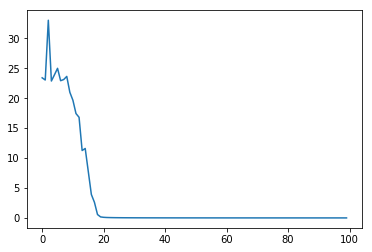

In [12]:
from tensorflow.examples.tutorials.mnist import input_data

# Construct a mini network for MNIST
inputs = Variable()
true_label = Variable()
inputs.value = np.random.normal(size=(28, 28, 1))
inputs.dloss_dvalue = np.random.normal(size=(28, 28, 1))

op1 = OpConv2D(16, 5, inputs) # Output is 28-5+1=24
op2 = OpAvgPool(2, op1)      # Output is 24/2=12
op3 = OpRelu(op2)

op4 = OpConv2D(16, 5, op3) # Output is 12-5+1=8
op5 = OpAvgPool(2, op4)      # Output is 8/2=4
op6 = OpRelu(op5)

op7 = OpConv2D(10, 3, op6) # Output is 4-3+1=2
op8 = OpAvgPool(2, op7)      # Output is 2/2=1

op9 = OpSoftmaxCrossEntropyLoss(op8, true_label)
ops_list = [op1,op2,op3,op4,op5,op6,op7,op8,op9]

# Run for a few iterations, make sure loss is going down
learning_rate = 0.2
inputs.value = np.random.normal(size=(28, 28, 1))

mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

num_its = 100
batch_size = 10
batch_x, batch_y = mnist.train.next_batch(batch_size)

loss_list = []

for it in range(num_its):
  loss_of_batch = 0.0
  
  for im in range(batch_size):
    inputs.value = np.reshape(batch_x[im], (28,28,1))
    true_label.value = batch_y[im]
  
    for op in ops_list:
      op.forward()

    loss_of_batch += ops_list[-1].value
    
    for op in reversed(ops_list):
      op.backward()
      op.gradient_step(learning_rate)
  
  loss_list.append(loss_of_batch)
  
  print("Iteration " + str(it) + " Loss: "+str(loss_of_batch))
  
  
plt.plot(range(num_its), loss_list)

## 3.1.6 Extra credit (5 points)

Extend the functionality of one of these operations (e.g. add stride, dilation, or padding to the 2D Convolution) or implement a new one (e.g. fully-connected layer).

## 3.1.6 Extra Credit Attempt
An attempt was made at padding the 2D Convolution (see funtion pad_inputs()). However, this was not completed in time for the assignment

# 3.2 Training an image classifier (40 points)

In [1]:
#@title (Hidden utility code: RUN ME FIRST) { display-mode: "form" }
#!git clone https://github.com/tensorflow/models.git /content >/dev/null
import sys
import math
sys.path.append('C:\\content\\tutorials\\image\\cifar10')
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['axes.facecolor'] = 'white'

import tensorflow as tf
tf.reset_default_graph()
try:
  tf.app.flags.FLAGS.f
except Exception:
  tf.app.flags.DEFINE_string('f', '', """Placeholder.""")
import cifar10
tf.app.flags.FLAGS.batch_size = 100
#from tensorflow.examples.models.tutorials.image.cifar10 import cifar10

def plot_filters(filters, xlabel=None, ylabel=None):
  print(filters.shape)
  # filters: height x width x channels x num_filters
  num_filters = filters.shape[3]
  filter_height = filters.shape[0]
  filter_width = filters.shape[1]
  filter_channels = filters.shape[2]
  spacing = 1
  rows = int(math.ceil(math.sqrt(num_filters)))
  cols = int(math.ceil(math.sqrt(num_filters)))
  plot = np.zeros((rows*(filter_height+spacing), cols*(filter_width+spacing), min(filter_channels, 3) ))
  
  min_value = np.min(filters)
  max_value = np.max(filters)
  filters = (filters - min_value) / (max_value - min_value)
  
  for f in range(num_filters):
    r = int(f/cols)
    c = f - r*cols
    plot[r*(filter_height+spacing):r*(filter_height+spacing)+filter_height,
        c*(filter_width+spacing):c*(filter_width+spacing)+filter_width,:] = filters[:,:,0:min(filter_channels, 3),f]
  
  plt.grid(False)
  plt.imshow(np.squeeze(plot))
  if xlabel is not None:
    plt.xlabel(xlabel)
  if ylabel is not None:
    plt.ylabel(ylabel)
  plt.show()

cifar10.maybe_download_and_extract()
images, labels = cifar10.inputs(False)
test_images, test_labels = cifar10.inputs(True)

## 3.2.1 Early stopping (15 points)

We have specified a very simple convolutional neural network to classify images from the Cifar-10 dataset.  We then provide a training loop to optimize the weights of the network.  Your task is to add Early Stopping (ES) to this training loop.  Validation accuracy should be measured periodically, and training should stop if the validation accuracy does not reach a new absolute maximum after some number of measurements (this is called the "patience"). After training, we then measure the test accuracy.  Before implementing ES, run the following cell to see a plot of the training loss and validation accuracy.  Report the test accuracy you have found with ES.

## Early Stopping Implementation
Early stopping is implemented by continually checking the value of the current accuracy within a certain incremental window. At each increment, the current accuracy is compared to the greatest accuracy found in the testing iterations, saving the current session if it is the greatest. The implementation includes a patience paramenter, to indicate how many increments it will search for a new maximum until quitting.

For this implementation, an approach was used to find the best validation increment and patience value similar to hyperparameter tuning. A large set of combinations was tested (see Early_Stopping_Parameter_Tuning PDF in directory Early_Stopping), finally resulting in the parameters chosen - a validation increment of 15 with a maximum patience of 25. While the values were recorded, none of the .ipynb notebooks with the results were saved (although there are several screenshots from results present in the directory).

## 3.2.2 Tuning hyperparameters (25 points)

The hyperparameters we have chosen are not necessarily optimal.  Pick two factors to search over (e.g. number of layers, filters per layer, learning rate, convolutional kernel size, etc.).  Then write a procedure that uses grid search to find the combination of these hyperparameters that yields the highest validation accuracy.  Finally, report the test accuracy achieved by this model.

## Tuning Hyperparameters Implementation
The two hyperparameters chosen for tuning in this implementation were learning rate and filter size. A large set of combinations was tested (see Hyperparameter_Tuning_Results PDF in directory Tuning_Hyperparameters), with the learning rate ranging from .001 to .5 and the filter size ranging from 32 to 128 (actual tested values can be seen below in lists or in the pdf). Unfortunately, there was a significant degredation of run time when attempting to calculate multiple hyperparameter combinations together. Therefore, the corresponding runs that led to each values are split into multiple notebooks, found in the Tuning_Hyperparameters directory. Each notebook is run over multiple filter sizes, keeping the learning rate values limited to one or two. The different notebooks can be found in files with the following format "Assignment3_learningrate_p#.ipynb", mostly split between 2 notebooks, with an exception of .2 being in three. In the end, the best parameters found in this testing were a learning rate of .06 and a filter size of 128.

Training... 2018-05-20 23:17:42.975054
Iteration 14/2000 ...
Iteration 29/2000 ...
Iteration 44/2000 ...
Iteration 59/2000 ...
Iteration 74/2000 ...
Iteration 89/2000 ...
Iteration 104/2000 ...
Iteration 119/2000 ...
Iteration 134/2000 ...
Iteration 149/2000 ...
Iteration 164/2000 ...
Iteration 179/2000 ...
Iteration 194/2000 ...
Iteration 209/2000 ...
Iteration 224/2000 ...
Iteration 239/2000 ...
Iteration 254/2000 ...
Iteration 269/2000 ...
Iteration 284/2000 ...
Iteration 299/2000 ...
Iteration 314/2000 ...
Iteration 329/2000 ...
Iteration 344/2000 ...
Iteration 359/2000 ...
Iteration 374/2000 ...
Iteration 389/2000 ...
Iteration 404/2000 ...
Iteration 419/2000 ...
Iteration 434/2000 ...
Iteration 449/2000 ...
Iteration 464/2000 ...
Iteration 479/2000 ...
Iteration 494/2000 ...
Iteration 509/2000 ...
Iteration 524/2000 ...
Iteration 539/2000 ...
Iteration 554/2000 ...
Iteration 569/2000 ...
Iteration 584/2000 ...
Iteration 599/2000 ...
Iteration 614/2000 ...
Iteration 629/2000 ...
I

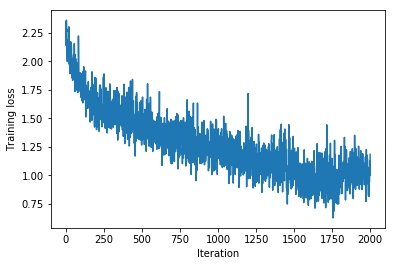

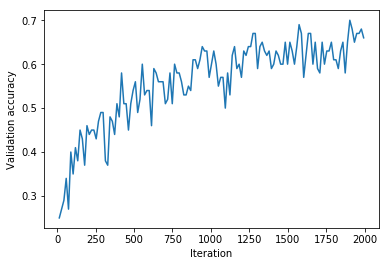

Test accuracy: 55.000001192092896%%


In [2]:
#Thweid: Added garbage collector in the attempt to speed up performance
import gc

#Thweid: Parameters included for hyperparameter tuning
#        Lists were used to batch process different learning rates with different filter sizes
#all_learning_rates = [.001, .005, .01, .02, .025, .05, .06 , .075, .1, .2, .5 ]
#all_filter_sizes = [ 32, 48, 64, 80, 96, 112, 128]
best_learning_rate = [.06] 
best_filter_size = [128]

#Parameters to keep track of the best total session through hyperparameter tuning
best_valid_acc = -1
best_sess_path = "/tmp/best-model.ckpt"

sess = tf.Session()
with sess.as_default():
  for lr in best_learning_rate:  
    for f in best_filter_size:

      tf.train.start_queue_runners()
      im_width = 24

      # Define placeholders for image and label
      y_ = tf.placeholder(tf.float32, [None, 10])
      x = tf.placeholder(tf.float32, [None, im_width, im_width, 3])

      # Define a convolutional neural network (CNN)
      cnnL1 = tf.layers.conv2d(x, f, 5, strides=(2,2), activation=tf.nn.relu)
      cnnL2 = tf.layers.conv2d(cnnL1, f, 5, activation=tf.nn.relu)
      cnnL3 = tf.layers.conv2d(cnnL2, f, 5, activation=tf.nn.relu)
      cnn = tf.reduce_sum(tf.reduce_sum(cnnL3, axis=1), axis=1)
      cnn = tf.contrib.layers.flatten(cnn)
      y_cnn = tf.layers.dense(cnn, 10)

      cross_entropy_cnn = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y_cnn))
      train_step_cnn = tf.train.GradientDescentOptimizer(lr).minimize(cross_entropy_cnn)

      correct_prediction_cnn = tf.equal(tf.argmax(y_cnn, 1), tf.argmax(y_, 1))
      accuracy_cnn = tf.reduce_mean(tf.cast(correct_prediction_cnn, tf.float32))

      tf.global_variables_initializer().run(session=sess)

      #Thweid: Additional values added for Early Stopping 
      #        Patience values from parameter tuning mentioned above
      #Use saver to save the current session with the best results from the validatio
      saver = tf.train.Saver()
      best_sess_path = "/tmp/model.ckpt"
      curr_max_accuracy = -1
      curr_patience = 0
      max_patience = 25
      validation_increment = 15
      quit_flag = False

      # Train
      print('Training... '+str(datetime.now()))
      valid_batch_xs, valid_batch_ys = sess.run([test_images, tf.one_hot(test_labels, 10)])
      train_losses = []
      test_accuracies = []
      valid_its = []
      valid_accuracies = []
        #Thweid: Iterations increased as patience and increment intervals requires 375 values to be iterated over before exit
      num_its = 2000
      for it in range(num_its):
        if (it+1) % validation_increment == 0:
          print('Iteration %d/%d ...' % (it, num_its))

          # Validation accuracy
          valid_acc_cnn = sess.run(accuracy_cnn, feed_dict={x: valid_batch_xs, y_: valid_batch_ys})
          valid_accuracies.append(valid_acc_cnn)
          valid_its.append(it)

          #Thweid:Increase patience
          #       Check to see if a new max validity is found, reseting the max patience if so
          #       Verify patience hasn't been exhausted, exiting if so
          curr_patience += 1
          if (valid_acc_cnn > curr_max_accuracy):
            saver.save(sess, best_sess_path)
            curr_max_accuracy = valid_acc_cnn
            curr_patience = 0
          if(curr_patience > max_patience):
            quit_flag = True 


        batch_xs, batch_ys = sess.run([images, tf.one_hot(labels, 10)])
        loss_cnn_out, _ = sess.run([cross_entropy_cnn, train_step_cnn], feed_dict={x: batch_xs, y_: batch_ys})

        train_losses.append(loss_cnn_out)

        #Thweid: If flag set to quit, then stop going through validation set
        if(quit_flag):
          break
      
      #Thweid: Add Check to see if this was the best accuracy, updating if so
      #        call garbage collector for attempted speedup
      if(curr_max_accuracy > best_valid_acc):
        best_valid_acc = curr_max_accuracy
        saver.save(sess, best_sess_path)
      gc.collect()

  #Restore saved session
  saver.restore(sess, best_sess_path)

  print('Testing... '+str(datetime.now()))
  # # Test trained model
  test_batch_xs, test_batch_ys = sess.run([test_images, tf.one_hot(test_labels, 10)])

  true_label = tf.argmax(y_, 1)
  cnn_label = tf.argmax(y_cnn, 1)
  acc_cnn_out, true_label_out, cnn_label_out = sess.run([accuracy_cnn, true_label, cnn_label], feed_dict={x: test_batch_xs,
                                          y_: test_batch_ys})        
        
# Plot train loss and validation accuracy
plt.plot(range(it+1), train_losses)
plt.ylabel('Training loss')
plt.xlabel('Iteration')
plt.show()
plt.plot(valid_its, valid_accuracies)
plt.ylabel('Validation accuracy')
plt.xlabel('Iteration')
plt.show()

print('Test accuracy: ' + str(acc_cnn_out*100)+ '%%')

If you are curious what the weights, activations, or confused images look like, we visualize them below.  Feel free to modify this code to inspect other aspects of your trained model.

with sess.as_default():
  # Show weights from the first layer
  print('Weights from the first layer')
  with tf.variable_scope("conv2d_1", reuse=True):
    weights = tf.get_variable('kernel')
  plot_filters(weights.eval())

  # Show activations from the first feature map
  print('Activations from the first feature map.')
  fmap = cnnL1.eval(feed_dict={x: test_batch_xs, y_: test_batch_ys})
  plot_filters(np.transpose(fmap[0:1,...], (1,2,0,3)))

  # Show images in a confusion matrix
  confusion = np.zeros((24,24,3,100))
  for b in range(true_label_out.shape[0]):
    confusion[:,:,:,true_label_out[b]*10 + cnn_label_out[b]] = test_batch_xs[b]

  plot_filters(confusion, ylabel='True label', xlabel='Guessed label')

